In [2]:
import pandas as pd
import os
from sqlalchemy import create_engine
import urllib

 
server = 'AMAN\\SQLEXPRESS'   
database = 'SpotifyDB'

 
params = urllib.parse.quote_plus('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + server + ';DATABASE=' + database + ';Trusted_Connection=yes;')
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)


df_song = pd.read_csv("data.csv")
df_artist = pd.read_csv("data_by_artist.csv")
df_genre = pd.read_csv("data_w_genres.csv")
df_year = pd.read_csv("data_by_year.csv")


df_song.to_sql(
    name='spotify_tracks',   
    con=engine,
    if_exists='replace',     
    index=False              
)

df_artist.to_sql(
    name='spotify_artist',
    con=engine,
    if_exists='replace',
    index=False
)

df_year.to_sql(
    name='spotify_year',
    con=engine,
    if_exists='replace',
    index=False
)

df_genre.to_sql(
    name='spotify_genre',
    con=engine,
    if_exists='replace',
    index=False
)



122

### Cleaning DataFrames

In [3]:
df_song.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo'],
      dtype='object')

In [4]:
# here change release date format to datetime

df_song['release_date'] = df_song['release_date'].astype('datetime64[ns]')

In [5]:
df_song.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   valence           170653 non-null  float64       
 1   year              170653 non-null  int64         
 2   acousticness      170653 non-null  float64       
 3   artists           170653 non-null  object        
 4   danceability      170653 non-null  float64       
 5   duration_ms       170653 non-null  int64         
 6   energy            170653 non-null  float64       
 7   explicit          170653 non-null  int64         
 8   id                170653 non-null  object        
 9   instrumentalness  170653 non-null  float64       
 10  key               170653 non-null  int64         
 11  liveness          170653 non-null  float64       
 12  loudness          170653 non-null  float64       
 13  mode              170653 non-null  int64         
 14  name

In [6]:
df_song.isnull().sum().sum()

np.int64(0)

In artists column we have some irrelevant values we only want \wand \s and remove else

In [7]:
df_song['artists'].replace('[^\w\s]', '', regex=True, inplace = True)

C:\Users\batma\AppData\Local\Temp\ipykernel_23500\2410817988.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_song['artists'].replace('[^\w\s]', '', regex=True, inplace = True)


In [8]:
df_song['artists'] = df_song['artists'].apply(lambda x:x.title())
df_song['name'] = df_song['name'].apply(lambda x:x.title())

In [9]:
df_song = df_song[['id','name','artists','year','duration_ms','valence','acousticness','danceability','energy', 'explicit','instrumentalness', 'key', 'liveness', 'loudness', 'mode','popularity','speechiness', 'tempo']]

In [10]:
df_song['id'].duplicated().sum()

np.int64(0)

Since id column is unnique so set it as index

In [11]:
df_song.set_index('id', verify_integrity = True, inplace = True)

In [12]:
df_song['duration_ms'] = df_song['duration_ms']/60000

In [13]:
df_song['duration_ms'] = df_song['duration_ms'].round(2)

In [14]:
df_song.rename(columns = {'duration_ms':'duration_min'}, inplace = True)

In [115]:
df_song.rename(columns = {'name':'track_name',
                          'artists':'artist_name',
                          'explicit':'explicit_flag',
                          'year':'release_year',
                         'tempo':'tempo_bpm'}, 
              inplace = True)

### Checking for Outliers

In [15]:
print(df_song.value_counts('explicit'))

explicit
0    156220
1     14433
Name: count, dtype: int64


In [16]:
df_duration_outliers = df_song['duration_min'].value_counts().sort_values(ascending = False)

<Axes: ylabel='Frequency'>

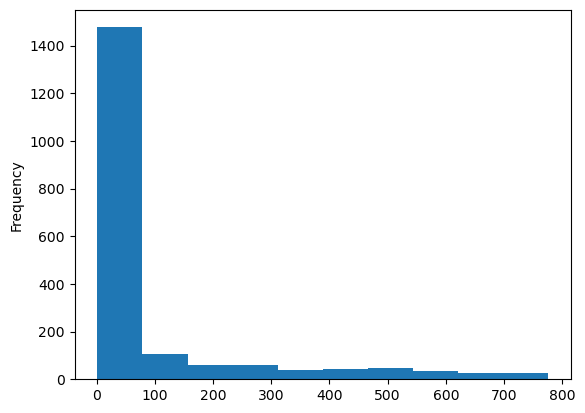

In [17]:
df_duration_outliers.plot(kind = 'hist')

In [18]:
long_songs = df_song.query("year<1980 and duration_min>10")
long_songs['name'].count()

np.int64(1893)

Analysis shows that extremely long tracks (>10 minutes) were mostly produced before 1980 — 1,893 out of 2,258 long songs.
To focus on mainstream trends, these historical outliers were separated for clarity, while still being highlighted in a dedicated section.

So we will seperate songs before 1980 to remove historical outliers and not to skew graphs

In [98]:
df_pre_1980 = df_song.query("year<=1980")

In [23]:
df_song = df_song.query("year>1980")

In [43]:
df_song['name'][df_song['duration_min'] > 10].count()

np.int64(349)

In [145]:
df_song.query("duration_min>15").mean(numeric_only = True)

release_year        1996.098765
duration_min          26.877160
valence                0.213090
acousticness           0.557975
danceability           0.281542
energy                 0.351174
explicit_flag          0.049383
instrumentalness       0.476223
key                    5.197531
liveness               0.248919
loudness             -17.663037
mode                   0.728395
popularity            41.222222
speechiness            0.089237
tempo_bpm            101.389605
dtype: float64

Here we can see there are 349 tracks with duration over 10 minutes which is rare in modern times as analysed these are violin sounds nature ambient sounds with average popularity of 41.
We will not remove these tracks as they dont have very low popularity and they wont do any much harm to our analysis.

In [48]:
df_song.value_counts('mode')

mode
1    54520
0    24731
Name: count, dtype: int64

In [71]:
df_song.query("valence>1 or valence <0")

,name,artists,year,duration_min,valence,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
id,,,,,,,,,,,,,,,,,


In [70]:
df_song.query("acousticness>1 or acousticness<0")

,name,artists,year,duration_min,valence,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
id,,,,,,,,,,,,,,,,,


In [69]:
df_song.query("danceability>1 or danceability<0")

,name,artists,year,duration_min,valence,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
id,,,,,,,,,,,,,,,,,


In [78]:
df_song.query("	loudness>0")

,name,artists,year,duration_min,valence,acousticness,danceability,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
id,,,,,,,,,,,,,,,,,
68Y3zzmt2XxzheQVGbbJt4,Genocide,Lil Darkie,2019,10.54,0.604,0.085000,0.457,0.965,1,0.000000,1,0.6970,0.457,1,70,0.4860,170.122
5Ve4qBYAThGLTOva0hhoTa,So Bad,Eminem,2010,5.42,0.774,0.304000,0.773,0.811,1,0.000000,1,0.1740,0.496,1,59,0.0882,81.037
6Moso5DtGXmTgS3DaXZrRB,Me Gusta Estar Contigo,Sergio Vega El Shaka,2004,2.31,0.968,0.495000,0.888,0.741,0,0.000000,5,0.0533,0.522,1,54,0.0573,105.789
49ErwcBYfYRPNBdRuPvpYA,We Are Your Friends - Justice Vs Simian,Justice Simian,2006,4.38,0.507,0.010400,0.615,0.970,0,0.384000,9,0.1780,1.342,0,61,0.1190,122.993
5PVv4YALJruehQKyAlwjfE,Must Be The Ganja,Eminem,2009,4.05,0.794,0.322000,0.728,0.801,1,0.000000,1,0.2440,0.161,1,54,0.2970,82.657
5sqkarfxe7UejHTlCtHCLS,Let Me Hear,Fear And Loathing In Las Vegas,2015,3.76,0.303,0.000145,0.175,0.995,0,0.000003,6,0.2140,1.023,0,64,0.2110,184.066
5mqzhMuUpvnMfwNz6iepmO,Welcome To The Party (With French Montana & Li...,Diplo French Montana Lil Pump Zhavia Ward,2018,3.03,0.486,0.114000,0.618,0.845,1,0.000000,2,0.4150,0.175,1,71,0.1320,171.921
4PkrQwJUTI6enWI3tDiJMe,Cosas Del Amor,Sergio Vega El Shaka,2004,3.32,0.883,0.152000,0.711,0.815,0,0.000000,2,0.3390,0.197,1,40,0.0524,101.239
0uqWsfvC6gz7L0BuGajUuv,Payback - Bass Chaserz Remix,Endymion Bass Chaserz,2019,3.96,0.220,0.076200,0.341,0.994,0,0.000000,1,0.3520,0.060,0,0,0.3740,157.607


Here I have detected unusual stuff that is 3 tracks over 0 db in loudness wihich is unusual, and I have also noticed that all those tracks have 
high energy (mostly ~ 0.9) which explains that unnusual behaviour.

We will keep those 13 songs in our df as they are negligible and wont affect much in our analysis

In [100]:
df_song.dtypes

name                 object
artists              object
year                  int64
duration_min        float64
valence             float64
acousticness        float64
danceability        float64
energy              float64
explicit              int64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
popularity            int64
speechiness         float64
tempo               float64
dtype: object

In [109]:
# In key there are only 12 range from 0 to 11 and lets validate it

df_song.value_counts('key').count()

np.int64(12)

Now push back this cleaned df into sql db

In [117]:
df_song.to_sql(
    name = 'spotify_tracks_cleaned',
    con = engine,
    index = False,
    if_exists = 'replace'
)

39

After pushing it to sql the id column which i set as index will get removed in sql in next time in another notebook i fetch df_song id column will  not be there, here i could just reset index and then push it but it's of no use as spotify provided me another index as primary key of whole numbers.